# Cell Tracking

Import statements

In [1]:
import os
import errno
import argparse
import datetime

import numpy as np

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import SGD, Adam
from tensorflow.python.keras.models import Sequential, Model

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import siamese_model
from deepcell.training import train_model_siamese_daughter


Using TensorFlow backend.


## Conv Based Training

In [ ]:
DATA_OUTPUT_MODE = 'siamese_daughters' 
BORDER_MODE = 'same'
RESIZE = False
RESHAPE_SIZE = None
NUM_FRAMES = 40  # get first N frames from each training folder

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/HeLa/S3'
#CONV_DATA_FILE = 'nuclear_movie_HeLa_{}'.format(DATA_OUTPUT_MODE)

direc_name = '/data/data/cells/HeLa/S3/set1/movie'
direc_data = '/data/npz_data/cells/HeLa/S3/movie/'
output_directory = '/data/npz_data/cells/HeLa/S3/set1/movie1/'
file_name_save = os.path.join( output_directory, 'nuclear_movie_HeLa_1_same.npz')

# Training directories are organized according to location within an image
num_x = 5 # Define num of horizontal samples
num_y = 5 # Define num of vertical samples
samples_to_drop = ['01_0'] # Some samples do not contain cells
# Build list of possible training directories (excluding those to be dropped)
training_direcs = ['0{}_{}'.format(i,j) for i in range(num_x) for j in range(num_y)]
training_direcs = [x for x in training_direcs if x not in samples_to_drop]
channel_names = ["slice"]

# Create output ditrectory, if necessary
#pathlib.Path( output_directory ).mkdir( parents=True, exist_ok=True )

# The following is left from Wills tests and may be useful:
# Check for channels_first or channels_last
#IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

#ROW_AXIS = 3 if IS_CHANNELS_FIRST else 2
#COL_AXIS = 4 if IS_CHANNELS_FIRST else 3
#CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 4

# create these directories if they do not exist
#for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
#    try:
#        os.makedirs(os.path.join(d, PREFIX))
#        print('Created new directory:', os.path.join(d, PREFIX))
#    except OSError as exc:  # Guard against race condition
#        if exc.errno != errno.EEXIST:
#            raise

### Make Training Data

In [ ]:
# Create the training data
make_training_data(window_size_x = 30, window_size_y = 30,
    direc_name = direc_name,
    montage_mode=False,
    file_name_save = file_name_save,
    training_direcs = training_direcs,
    channel_names = channel_names,
    dimensionality = 3,
    annotation_name = "",
    raw_image_direc = "processed",
    annotation_direc = "annotated",
    border_mode = "same",
    output_mode = "conv",
    num_frames = 40,
    reshape_size = None,
    display = False,
    num_of_frames_to_display = 5,
    verbose = True)

# The following is left from Wills tests and may be useful:
#make_training_data(
#    dimensionality=3,
#    direc_name=os.path.join(DATA_DIR, PREFIX),
#    file_name_save=os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE),
#    channel_names=['slice'],  # for iterating over stacks of images from a montage
#    training_direcs=['set6'],
#    output_mode=DATA_OUTPUT_MODE,
#    window_size_x=30,
#    window_size_y=30,
#    window_size_z=3,
#    border_mode=BORDER_MODE,
#    reshape_size=None if not RESIZE else RESHAPE_SIZE,
#    process=True,
#    process_std=True,
#    display=False,
#    num_frames=NUM_FRAMES,
#    num_of_frames_to_display=5,
#    verbose=True,
#    montage_mode=True,  # annotation folder has montaged sub-dirs
#    annotation_name='',  # basically channel name but for annotated images
#    raw_image_direc='stacked_raw',
#    annotation_direc='annotated/all_montages')

#if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE) + '.npz'):
#    print('\nData saved to', os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE) + '.npz')
#else:
#    raise Exception('Your data file did not save properly')

In [ ]:
# Load the training data from NPZ into a numpy array
#training_data = np.load(os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE + '.npz'))
training_data = np.load('{}{}.npz'.format(direc_data, dataset))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

in_shape = (32, 32, 1)

# Set up training parameters
n_epoch = 10
batch_size = 128
#frames_per_batch = 10
optimizer = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.001, decay=0.99)

In [ ]:
# First, create the Siamese model

# Instantiate the model
comparator_model = siamese_model(input_shape=in_shape)

# Train the model
train_model_siamese_daughter(
    model=comparator_model,
    dataset=dataset,
    optimizer=optimizer,
    expt='',
    it=0,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save='/data/models/cells/HeLa/S3',
#   direc_save=os.path.join(MODEL_DIR, PREFIX),
#   direc_data=os.path.join(NPZ_DIR, PREFIX),
    direc_data=direc_data,
    lr_sched=lr_sched,
#   class_weight=training_data['class_weights'],
    rotation_range=0,
    flip=True,
    shear=False)


## Start here with a pre-trained model

In [2]:
# If this is your starting point, you will need some housekeeping
from deepcell.model_zoo import siamese_model
from deepcell import get_data

direc_data = '/data/npz_data/cells/HeLa/S3/movie/'
dataset = 'nuclear_movie_hela2-3_same'
MODEL_DIR = '/data/models'
PREFIX = 'cells/HeLa/S3'

in_shape = (32, 32, 1)

# Now we can load some data to test on 
# For this example we load some data that we could train on:
training_data_file = '{}{}.npz'.format(direc_data, dataset)
train_dict, val_dict = get_data(training_data_file, mode='siamese_daughters')

# We need to set a few parameters for the following functions
data_format = K.image_data_format()

if data_format == 'channels_first':
    channel_axis = 1
    row_axis = 3
    col_axis = 4
    time_axis = 2
if data_format == 'channels_last':
    channel_axis = 4
    row_axis = 2
    col_axis = 3
    time_axis = 1
x = np.asarray(train_dict['X'], dtype=K.floatx())
y = np.array(train_dict['y'], dtype='int32')

# Now we need to re-instantiate the model and load weights
siamese_weights_file = '2018-08-15_nuclear_movie_hela2-3_same__0.h5'
siamese_weights_file = os.path.join(MODEL_DIR, PREFIX, siamese_weights_file)

comparator_model = siamese_model(input_shape=in_shape)
comparator_model.load_weights(siamese_weights_file)

In [3]:
# Create our first movie and annotation to test the tracker
print('X shape', x.shape)
print('y shape', y.shape)

first_movie = np.zeros(x[0].shape)
first_annotation = np.zeros(y[0].shape)

first_movie = x[0]
first_annotation = y[0]

print('Movie shape', first_movie.shape)
print('Annotation shape', first_annotation.shape)


X shape (42, 40, 216, 256, 1)
y shape (42, 40, 216, 256, 1)
Movie shape (40, 216, 256, 1)
Annotation shape (40, 216, 256, 1)


## Import Tracking Functions

In [4]:
from deepcell.tracking import cell_tracker

In [5]:
test_tracker = cell_tracker(
    first_movie, 
    first_annotation, 
    comparator_model, 
    track_length=5)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


#### Verify Annotation Clean up

Labels before:  [0 1 2 3 4 5 6 7 8 9]
Labels after:   [0 1 2 3 4 5 6 7 8 9]


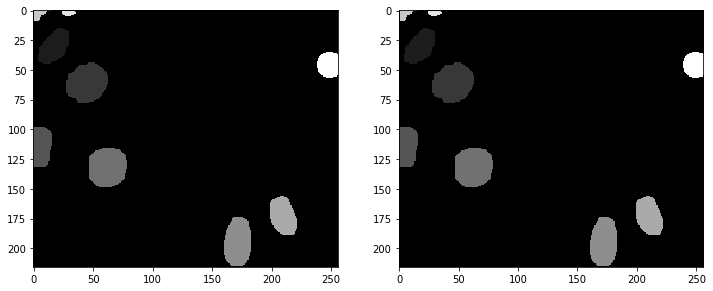

In [6]:
import matplotlib.pyplot as plt
from skimage.io import imshow

test_tracker._clean_up_annotations()

# Compare labels in existence
unique_cells_before = np.unique(first_annotation[0])
unique_cells_after = np.unique(test_tracker.y[0])
print('Labels before: ',unique_cells_before)
print('Labels after:  ',unique_cells_after)

# Compare 2 images
before = first_annotation[0,:,:,0]
after = test_tracker.y[0,:,:,0]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(before, interpolation='none', cmap='gray')
ax[1].imshow(after, interpolation='none', cmap='gray')
plt.show()

## Build the Cost Matrix

In [ ]:

first_frame = 0
first_cost_matrix = test_tracker._get_cost_matrix(first_frame)



## Linear Assignment Problem

## Track Cells

In [9]:
trial = cell_tracker(first_movie, first_annotation, comparator_model, track_length=5, birth=0.5, death=0.5)
trial._track_cells()

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Tracking frame 1
Tracking frame 2
Tracking frame 3
Tracking frame 4
Tracking frame 5
Tracking frame 6
Tracking frame 7
Tracking frame 8
Tracking frame 9
Tracking frame 10
Tracking frame 11
Tracking frame 12
Tracking frame 13
Tracking frame 14
Tracking frame 15
Tracking frame 16
Tracking frame 17
Tracking frame 18
Tracking frame 19
Tracking frame 20
Tracking frame 21
Tracking frame 22
Tracking frame 23
Tracking frame 24
Tracking frame 25
Tracking frame 26
Tracking frame 27
Tracking frame 28
Adding new track
Tracking frame 29
Adding new track
Tracking frame 30
Tracking frame 31
Tracking frame 32
Tracking frame 33
Tracking frame 34
Tracking frame 35
Tracking frame 36
Tracking frame 37
Tracking frame 38
Tracking frame 39


# Visualize the Results

In [10]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def get_js_video(images, batch=0, channel=0):
    fig = plt.figure()    
    ims = []
    for i in range(images.shape[1]):
        im = plt.imshow(images[batch, i, :, :, channel], animated=True, cmap='jet', vmin=0, vmax=16)
        ims.append([im])
        ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1000)
    return HTML(ani.to_jshtml())

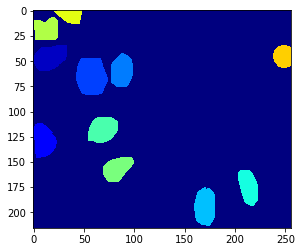

In [11]:
get_js_video(y)

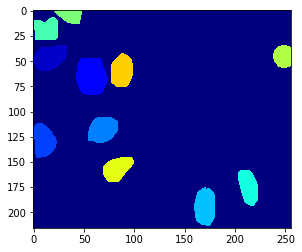

In [12]:
get_js_video(np.expand_dims(trial.y_tracked, axis=0))